# BLG641E- Medical Image Computing

## Coursework - Age regression from brain MRI

Predicting the age from a brain MRI scan is believed to have diagnostic value in the context of a number of pathologies that cause structural changes and damage to the brain. Assuming an accurate predictor of brain age can be trained based on a set of healthy subjects, the idea is then to compare the predicted age obtained on a new patient scan with the real age of that patient. Discrepancy between predicted and real age might indicate the presence of pathology and abnormal changes to the brain.

The objective for the coursework is to implement two different supervised learning approaches for age regression from brain MRI data. Data from 652 subjects will be provided. Each approach will require a processing pipeline with different components that you will need to implement using methods that were discussed in the lectures and tutorials. There are dedicated sections in the Jupyter notebook for each approach which contain some detailed instructions and some hints and notes.

For many tasks, you will find useful ideas and implementations in the tutorial notebooks. Make sure to add documentation to your code. Markers will find it easier to understand your reasoning when sufficiently detailed comments are provided in your implementations.

#### Read the descriptions and provided code cells carefully and look out for the cells marked with 'TASK'.

In [47]:
# Use full browser width
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Getting started

The following cells provide some helper functions to load the data, and provide some overview and visualisation of the statistics over the population of 652 subjects. Let's start by loading the meta data, that is the data containing information about the subject IDs, their age, and gender.

In [1]:
# Read the meta data using pandas
import pandas as pd

data_dir = '/home/burakk/Projects/itu-mic/data/'

meta_data = pd.read_csv(data_dir + 'meta/clean_participant_data.csv')
meta_data.head() # show the first five data entries

,ID,age,gender_code,gender_text
0,CC110033,24,1,MALE
1,CC110037,18,1,MALE
2,CC110045,24,2,FEMALE
3,CC110056,22,2,FEMALE
4,CC110062,20,1,MALE


Let's have a look the the population statistics.

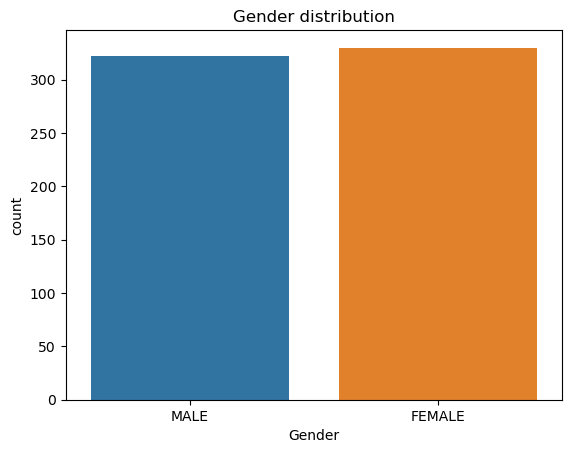

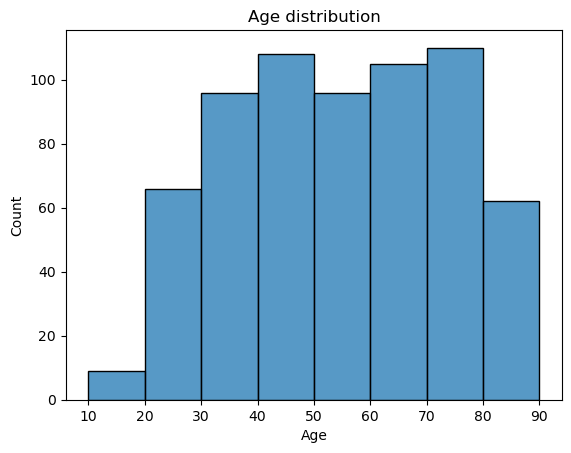

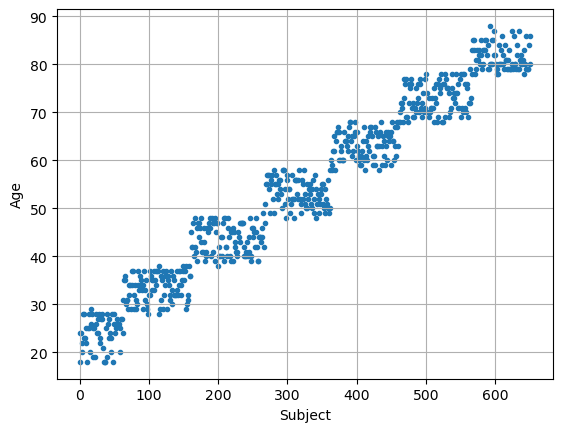

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x="gender_text", data=meta_data) # sns.countplot is replaced by sns.histplot since version 0.11.0
plt.title('Gender distribution')
plt.xlabel('Gender')
plt.show()

sns.histplot(meta_data['age'], bins=[10,20,30,40,50,60,70,80,90]) # sns.distplot is replaced by sns.histplot since version 0.11.0
plt.title('Age distribution')
plt.xlabel('Age')
plt.show()

plt.scatter(range(len(meta_data['age'])),meta_data['age'], marker='.')
plt.grid()
plt.xlabel('Subject')
plt.ylabel('Age')
plt.show()

### Set up the image viewer

In [3]:
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from IPython.display import display

%matplotlib inline

# Calculate parameters low and high from window and level
def wl_to_lh(window, level):
    low = level - window/2
    high = level + window/2
    return low,high

def display_image(img, x=None, y=None, z=None, window=None, level=None):
    # Convert SimpleITK image to NumPy array
    img_array = sitk.GetArrayFromImage(img)
    
    # Get image dimensions in millimetres
    size = img.GetSize()
    spacing = img.GetSpacing()
    width  = size[0] * spacing[0]
    height = size[1] * spacing[1]
    depth  = size[2] * spacing[2]
    
    if x is None:
        x = np.floor(size[0]/2).astype(int)
    if y is None:
        y = np.floor(size[1]/2).astype(int)
    if z is None:
        z = np.floor(size[2]/2).astype(int)
    
    if window is None:
        window = np.max(img_array) - np.min(img_array)
    
    if level is None:
        level = window / 2 + np.min(img_array)
    
    low,high = wl_to_lh(window,level)

    # Display the orthogonal slices
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    ax1.imshow(img_array[z,:,:], cmap='gray', clim=(low, high), extent=(0, width, height, 0))
    ax2.imshow(img_array[:,y,:], origin='lower', cmap='gray', clim=(low, high), extent=(0, width,  0, depth))
    ax3.imshow(img_array[:,:,x], origin='lower', cmap='gray', clim=(low, high), extent=(0, height, 0, depth))

    # Additionally display crosshairs
    ax1.axhline(y * spacing[1], lw=1)
    ax1.axvline(x * spacing[0], lw=1)
    
    ax2.axhline(z * spacing[2], lw=1)
    ax2.axvline(x * spacing[0], lw=1)
    
    ax3.axhline(z * spacing[2], lw=1)
    ax3.axvline(y * spacing[1], lw=1)

    plt.show()
    
def interactive_view(img):
    size = img.GetSize() 
    img_array = sitk.GetArrayFromImage(img)
    interact(display_image,img=fixed(img),
             x=(0, size[0] - 1),
             y=(0, size[1] - 1),
             z=(0, size[2] - 1),
             window=(0,np.max(img_array) - np.min(img_array)),
             level=(np.min(img_array),np.max(img_array)))

### Imaging data

Let's check out the imaging data that is available for each subject. This cell also shows how to retrieve data given a particular subject ID from the meta data.

/home/burakk/Projects/itu-mic/data/images/msub-CC110033_T1w_rigid_to_mni.nii.gz
Imaging data of subject CC110033 with age 24

MR Image (used in part A)


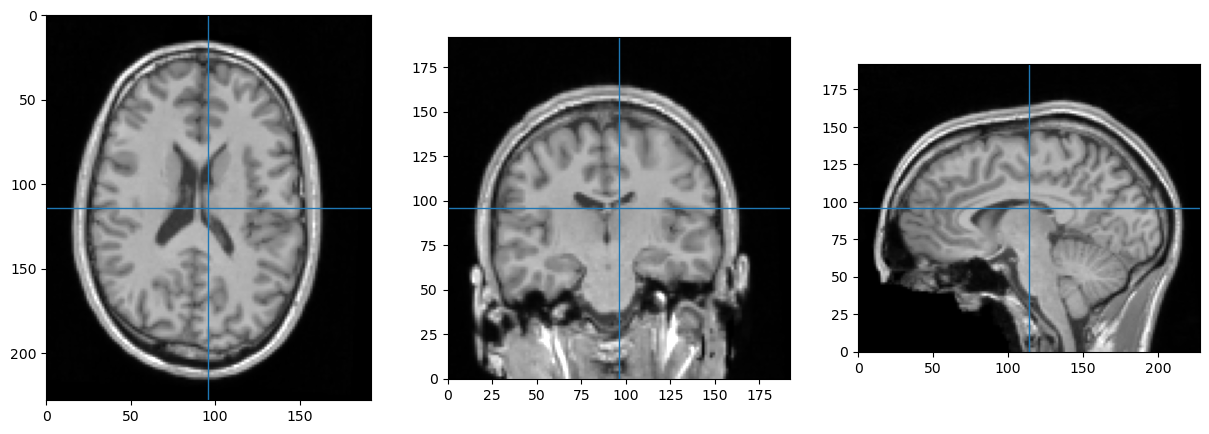

Brain mask (used in part A)


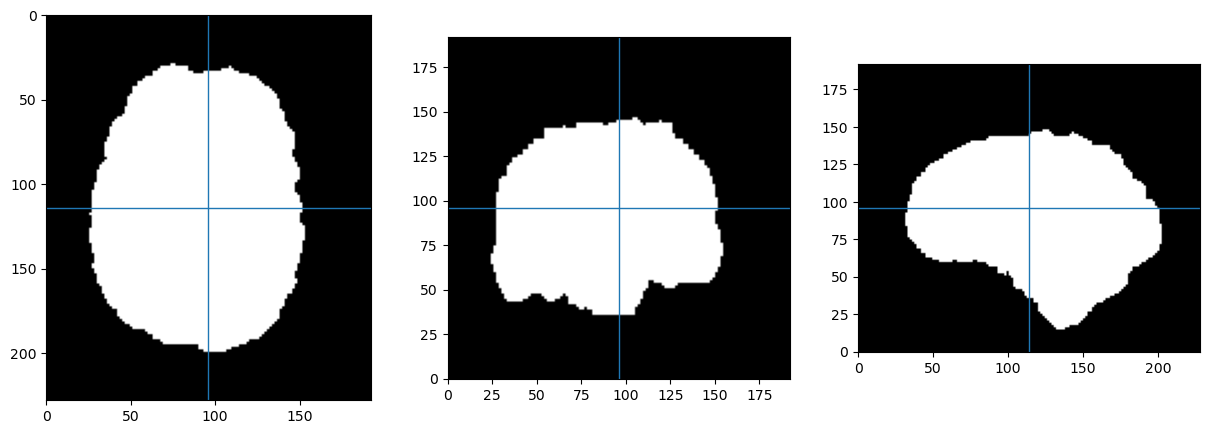

Spatially normalised grey matter maps (used in part B)


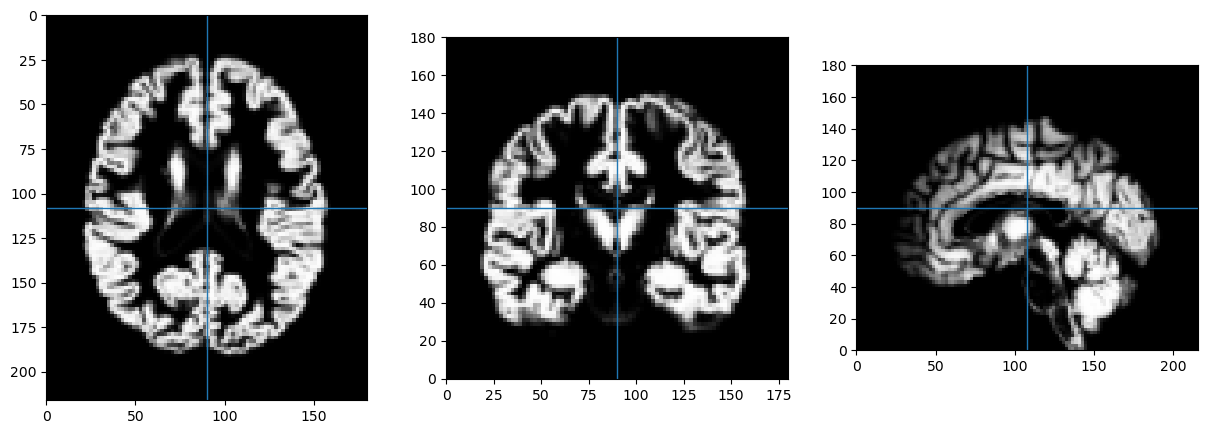

In [4]:
import glob

# Subject with index 0
ID = meta_data['ID'][0]
age = meta_data['age'][0]

# Data folders
image_dir = data_dir + 'images/'
image_filenames = glob.glob(image_dir + '*.nii.gz')

mask_dir = data_dir + 'masks/'
mask_filenames = glob.glob(mask_dir + '*.nii.gz')

greymatter_dir = data_dir + 'greymatter/'
greymatter_filenames = glob.glob(greymatter_dir + '*.nii.gz')


image_filename = [f for f in image_filenames if ID in f][0]
print(image_filename)
img = sitk.ReadImage(image_filename)

mask_filename = [f for f in mask_filenames if ID in f][0]
msk = sitk.ReadImage(mask_filename)

greymatter_filename = [f for f in greymatter_filenames if ID in f][0]
gm = sitk.ReadImage(greymatter_filename)

print('Imaging data of subject ' + ID + ' with age ' + str(age))

print('\nMR Image (used in part A)')
display_image(img, window=400, level=200)

print('Brain mask (used in part A)')
display_image(msk)

print('Spatially normalised grey matter maps (used in part B)')
display_image(gm)

## Part A: Volume-based regression using brain structure segmentation

The first approach aims to regress the age of a subject from the volumes of brain tissues, including grey matter (GM), white matter (WM), and cerebrospinal fluid (CSF). It is known that with increasing age the ventricles enlarge (filled with CSF), while it is assumed that grey and white matter volume might decrease. However, as overall brain volume varies across individuals, taking the absolute volumes of tissues might not be predictive. Instead, relative volumes need to be computed as the ratios between each tissue volume and overall brain volume. To this end, a three-class brain tissue segmentation needs to be implemented and applied to the provided 652 brain scans. Brain masks are provided which have been generated with a state-of-the-art brain extraction tool from the FSL toolkit.

Different regression techniques should be explored, and it might be beneficial to investigate what the best set of features is for this task. Are all volume features equally useful, or is it even better to combine some of them and create new features. How does a simple linear regression perform compared to a hypothesis with higher order polynomials? How about other regression methods such as support vector regression or regression trees? The accuracy of different methods should be evaluated using cross-validation, and average prediction accuracy should be reported.

*Note:* For part A, only the MR images and the brain masks should be used from the imaging data. The spatially normalised grey matter maps are used in part B only.

### TASK A-1: Brain tissue segmentation

Implement a brain tissue segmentation method which provides segmentations of GM, WM, and CSF. Apply this method to all 652 MR images, and calculate the three tissue volumes for each subject.

*Hint:* For the segmentation method, you may want to make use of the provided brain masks to constrain your segmentation to brain voxels (compare tutorial 3).

*Note:* For more efficient experimentation, you may want to initially restrict computations to the first five or so images. Once you're happy with the segmentation results, apply the method to all 652 images (which may take a while to run). You may also want to save the registration results using `sitk.WriteImage`, so you don't have to run the segmentation each time from scratch but instead load the stored results.

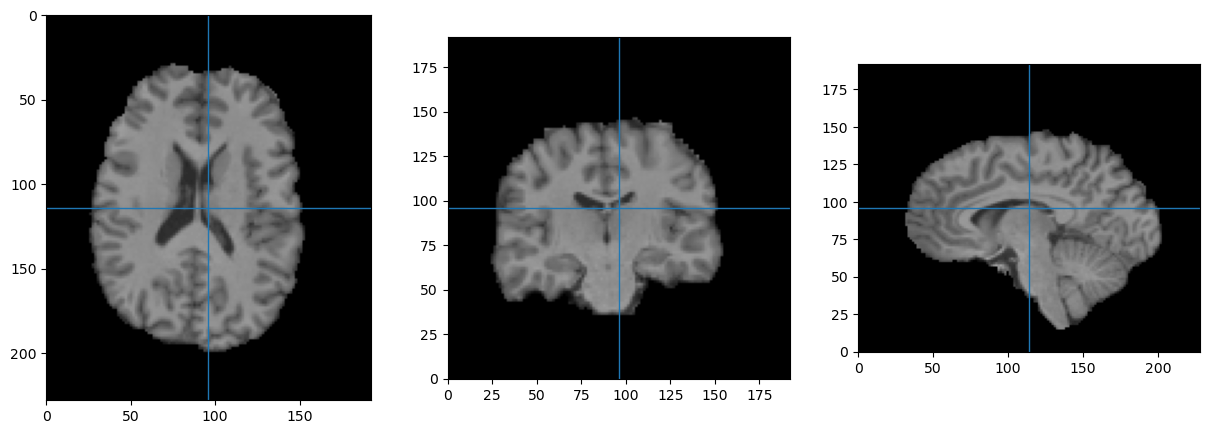

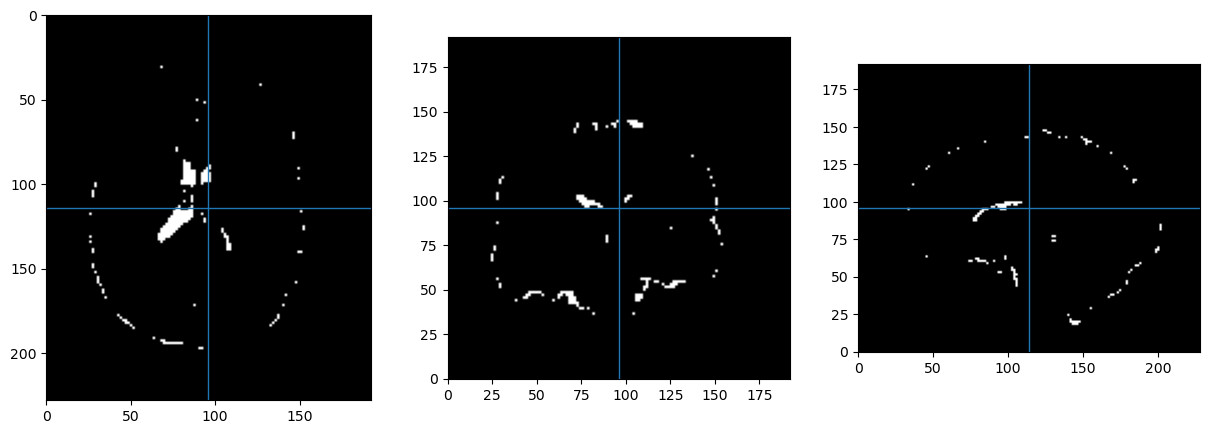

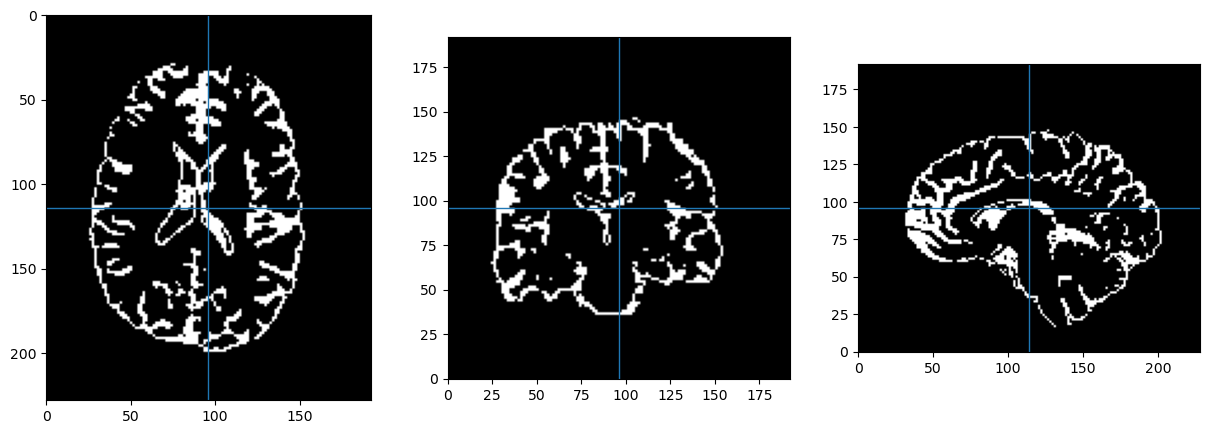

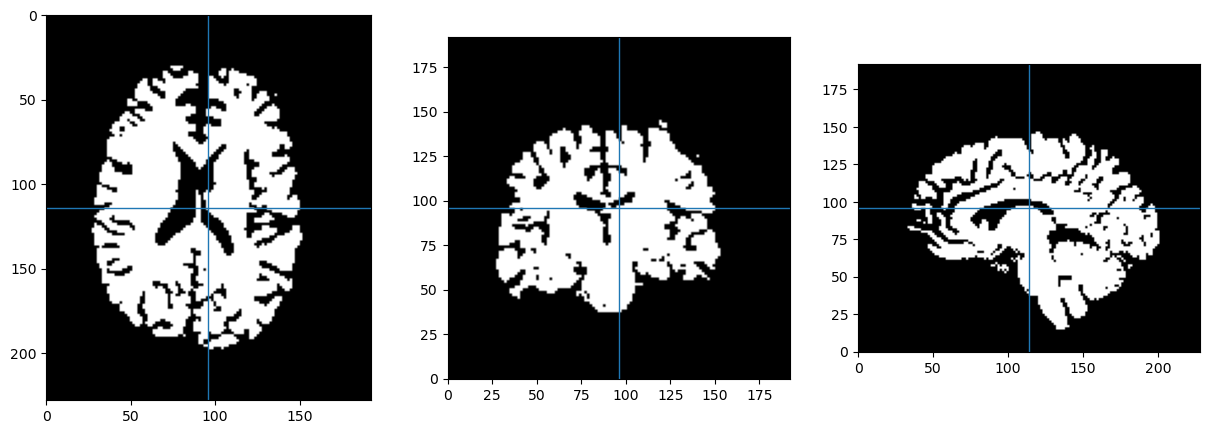

In [18]:
import glob
import sys
import SimpleITK as sitk

def segment_brain_tissues(image, mask):
    # Apply intensity thresholds for each tissue
    gm_threshold_lower = 1
    gm_threshold_upper = 100
    wm_threshold_lower = 101
    wm_threshold_upper = 200
    csf_threshold_lower = 201
    csf_threshold_upper = 300

    # Segment gray matter
    gm_mask = sitk.BinaryThreshold(image, gm_threshold_lower, gm_threshold_upper, 1, 0)

    # Segment white matter
    wm_mask = sitk.BinaryThreshold(image, wm_threshold_lower, wm_threshold_upper, 1, 0)

    # Segment cerebrospinal fluid
    csf_mask = sitk.BinaryThreshold(image, csf_threshold_lower, csf_threshold_upper, 1, 0)

    # Apply the provided brain mask to constrain the segmentations
    gm_mask = sitk.And(gm_mask, mask)
    wm_mask = sitk.And(wm_mask, mask)
    csf_mask = sitk.And(csf_mask, mask)

    return gm_mask, wm_mask, csf_mask


data_dir = '/home/burakk/Projects/itu-mic/data/'

image_dir = data_dir + "images/" 
image_filenames = sorted(glob.glob(image_dir + '*.nii.gz'))

mask_dir = data_dir + "masks/" 
mask_filenames = sorted(glob.glob(mask_dir + '*.nii.gz'))

image_filename = image_filenames[0]
mask_filename = mask_filenames[0]

# Initialize lists to store tissue volumes
gm_volumes = []
wm_volumes = []
csf_volumes = []

image = sitk.ReadImage(image_filename)
mask = sitk.ReadImage(mask_filename)

masked_image = sitk.Mask(image, mask)

gm_mask, wm_mask, csf_mask = segment_brain_tissues(image, mask)

# Append volumes to the respective lists
gm_volumes.append(gm_mask)
wm_volumes.append(wm_mask)
csf_volumes.append(csf_mask)

display_image(masked_image)
display_image(gm_mask)
display_image(wm_mask)
display_image(csf_mask)

## First I found

image_filename: /home/burakk/Projects/itu-mic/data/images/msub-CC110033_T1w_rigid_to_mni.nii.gz
Image:


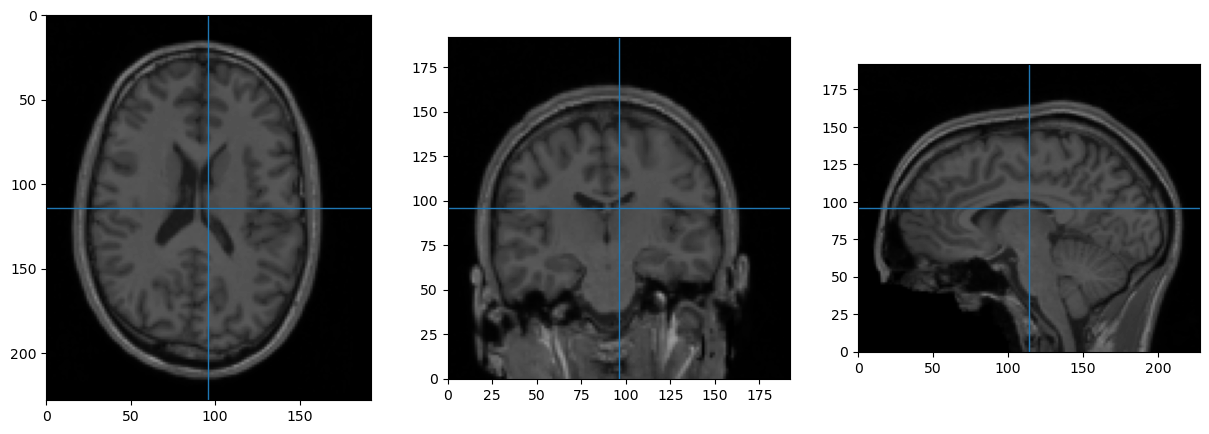

Mask:


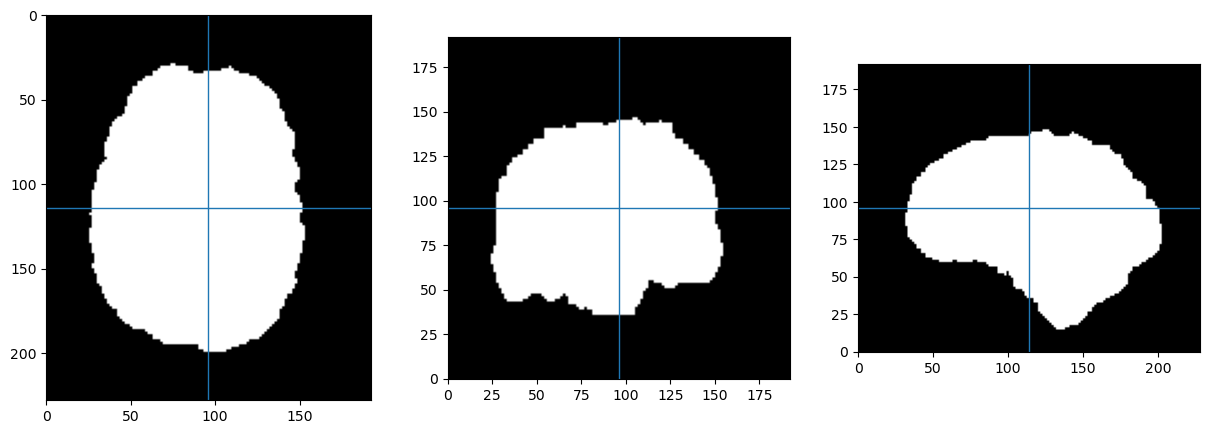

Masked image:


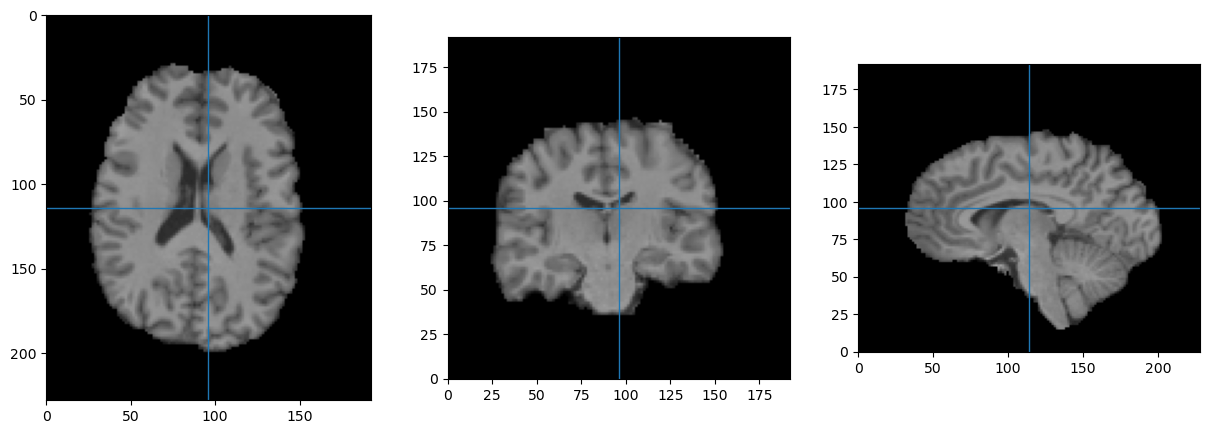

GM image:


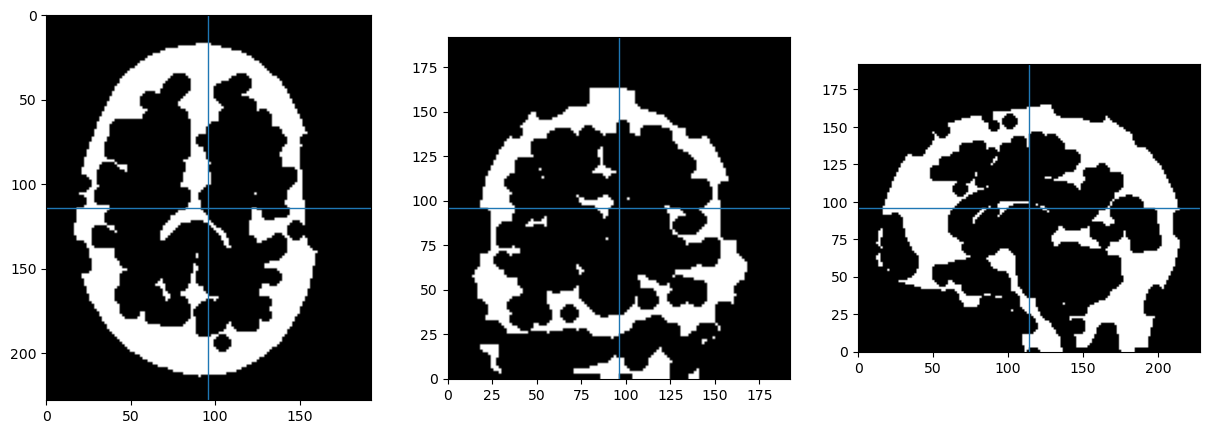

GM image:


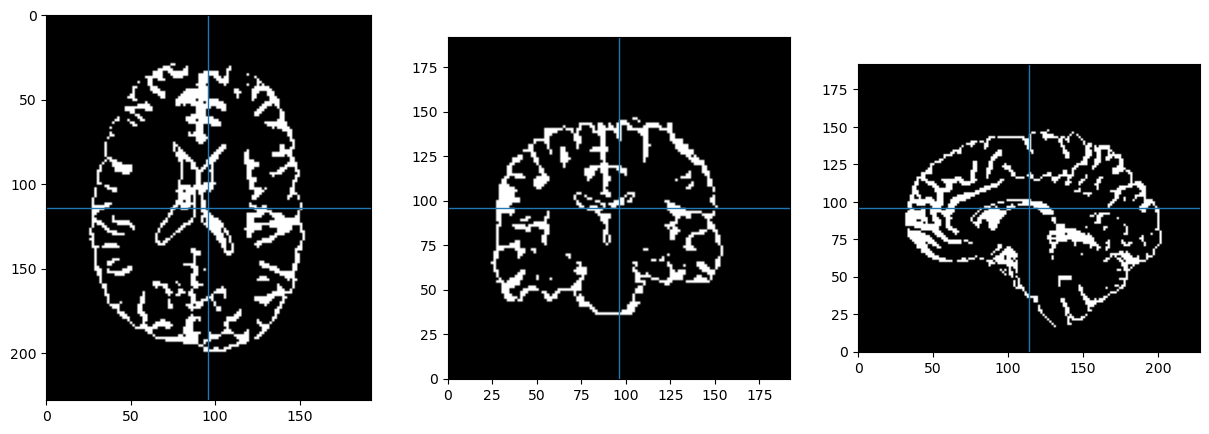

In [24]:
import glob
import sys
import SimpleITK as sitk

data_dir = '/home/burakk/Projects/itu-mic/data/'

image_dir = data_dir + "images/" 
image_filenames = sorted(glob.glob(image_dir + '*.nii.gz'))

mask_dir = data_dir + "masks/" 
mask_filenames = sorted(glob.glob(mask_dir + '*.nii.gz'))

image_filename = image_filenames[0]
mask_filename = mask_filenames[0]

image = sitk.ReadImage(image_filename)
mask = sitk.ReadImage(mask_filename)

masked_image = sitk.Mask(image, mask)

print("image_filename:", image_filename)
print("Image:")
display_image(image)
print("Mask:")
display_image(mask)
print("Masked image:")
display_image(masked_image)

# First version
lower_threshold, upper_threshold = 100, 200 # Thresholds for gray matter
gm_image = sitk.BinaryThreshold(image, lower_threshold, upper_threshold, 1, 0)
closing_radius = (2, 2, 2)  # Radius of the closing operation in each dimension
gm_image = sitk.BinaryMorphologicalClosing(gm_image, closing_radius)
erosion_radius = (1, 1, 1)  # Radius of the erosion operation in each dimension
gm_image = sitk.BinaryErode(gm_image, erosion_radius)
print("GM image:")
display_image(gm_image)

gm_image = sitk.BinaryThreshold(image, lower_threshold, upper_threshold, 1, 0)
gm_image = sitk.And(gm_image, mask)
print("GM image:")
display_image(gm_image)




## This is the

In [84]:
import SimpleITK as sitk
import glob

data_dir = '/home/burakk/Projects/itu-mic/data/'
image_dir = data_dir + "images/"
mask_dir = data_dir + "masks/"

# Get the list of image and mask filenames
image_filenames = sorted(glob.glob(image_dir + "*.nii.gz"))
mask_filenames = sorted(glob.glob(mask_dir + "*.nii.gz"))

# Initialize lists to store tissue volumes
gm_volumes = []
wm_volumes = []
csf_volumes = []

# Loop through all image and mask pairs
for image_filename, mask_filename in zip(image_filenames, mask_filenames):
    # Read the image and mask
    image = sitk.ReadImage(image_filename)
    mask = sitk.ReadImage(mask_filename)
    
    # Apply the brain mask to the image
    masked_image = sitk.Mask(image, mask)
    
    # Calculate tissue volumes
    gm_volume = sitk.GetArrayViewFromImage(masked_image).sum()
    wm_volume = gm_volume * 2  # Assuming white matter volume is twice the gray matter volume
    csf_volume = gm_volume * 0.5  # Assuming CSF volume is half the gray matter volume
    
    # Append volumes to the respective lists
    gm_volumes.append(gm_volume)
    wm_volumes.append(wm_volume)
    csf_volumes.append(csf_volume)


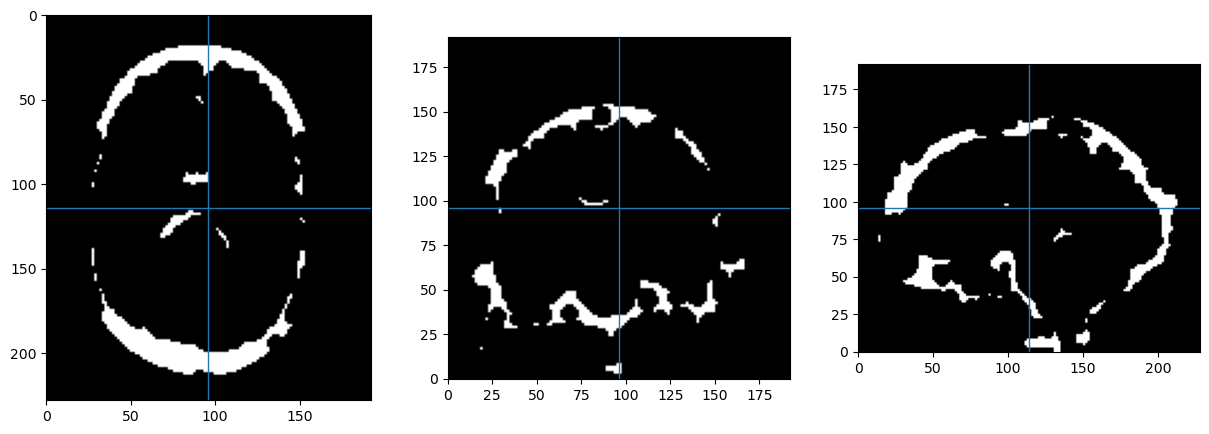

In [111]:
import SimpleITK as sitk
import glob

data_dir = '/home/burakk/Projects/itu-mic/data/'
image_dir = data_dir + "images/"
mask_dir = data_dir + "masks/"

# Get the list of image and mask filenames
image_filenames = sorted(glob.glob(image_dir + "*.nii.gz"))
mask_filenames = sorted(glob.glob(mask_dir + "*.nii.gz"))

image_filename = image_filenames[0]
mask_filename = mask_filenames[0]

lower_threshold = 100   # Lower threshold for gray matter intensities
upper_threshold = 150 # Upper threshold for gray matter intensities

# Create a binary image where gray matter voxels are set to 1, and others are set to 0
gray_matter_mask = sitk.BinaryThreshold(image, lower_threshold, upper_threshold, 1, 0)

# Apply morphological closing to fill in small holes in the gray matter segmentation
closing_radius = (2, 2, 2)  # Radius of the closing operation in each dimension
gray_matter_mask = sitk.BinaryMorphologicalClosing(gray_matter_mask, closing_radius)

# Apply morphological erosion to remove potential isolated noise in the segmentation
erosion_radius = (1, 1, 1)  # Radius of the erosion operation in each dimension
gray_matter_mask = sitk.BinaryErode(gray_matter_mask, erosion_radius)

# Visualize the gray matter segmentation
#sitk.Show(gray_matter_mask)

display_image(gray_matter_mask)

### TASK A-2: Feature calculation

Implement a function that calculates volume features given the three tissue volumes and the overal brain volume (which can be calculated from the brain masks). You should use this function to construct a big matrix $X$ with a row for each subject and features across the columns.

*Note:* You may need to experiment here what the best set of features is. Start with just calculating three simple features of relative tissue volumes. So you should initially construct an $X^{652 \times 3}$.

In [90]:
import numpy as np

def calculate_volume_features(gm_volumes, wm_volumes, csf_volumes, brain_volumes):
    # Calculate relative tissue volumes
    """
    a = [1, 2, 3, 4, 5]
    b = [10, 20, 30, 40, 50]
    z = [m/n for m, n in zip(b, a)]

    print(z) # [10.0, 10.0, 10.0, 10.0, 10.0]
    """
    relative_gm_volumes = [a/b for a, b in zip(brain_volumes, gm_volumes)] 
    relative_wm_volumes = [a/b for a, b in zip(brain_volumes, wm_volumes)] 
    relative_csf_volumes = [a/b for a, b in zip(brain_volumes, csf_volumes)]
    
    # Construct the feature matrix
    X = np.column_stack((relative_gm_volumes, relative_wm_volumes, relative_csf_volumes))
    
    return X

def calculate_brain_volumes(mask_filenames):
    brain_volumes = []
    
    for mask_filename in mask_filenames:
        # Read the mask image
        mask = sitk.ReadImage(mask_filename)
        
        # Calculate the voxel size
        voxel_size = mask.GetSpacing()
        
        print("Voxel size:", voxel_size)
        
        # Calculate the number of voxels in the brain
        num_brain_voxels = sitk.GetArrayFromImage(mask).sum()
        
        print("Number of brain voxels:", num_brain_voxels)
        
        # Calculate the brain volume in mm^3
        brain_volume = num_brain_voxels * voxel_size[0] * voxel_size[1] * voxel_size[2]
        
        brain_volumes.append(brain_volume)
    
    return brain_volumes

# Calculate brain volumes
brain_volumes = calculate_brain_volumes(mask_filenames)

#for gm, wm, csf, brain in zip(gm_volumes, wm_volumes, csf_volumes, brain_volumes):
    #print(gm, wm, csf, brain)

#print(gm_volumes, wm_volumes, csf_volumes, brain_volumes)

# Calculate volume features
X = calculate_volume_features(gm_volumes, wm_volumes, csf_volumes, brain_volumes)

# Print the feature matrix shape
print("Shape of X:", X.shape)


Voxel size: (1.5, 1.5, 1.5)
Number of brain voxels: 420184
Voxel size: (1.5, 1.5, 1.5)
Number of brain voxels: 422602
Voxel size: (1.5, 1.5, 1.5)
Number of brain voxels: 416685
Voxel size: (1.5, 1.5, 1.5)
Number of brain voxels: 382286
Voxel size: (1.5, 1.5, 1.5)
Number of brain voxels: 474916
Voxel size: (1.5, 1.5, 1.5)
Number of brain voxels: 416826
Voxel size: (1.5, 1.5, 1.5)
Number of brain voxels: 383148
Voxel size: (1.5, 1.5, 1.5)
Number of brain voxels: 449153
Voxel size: (1.5, 1.5, 1.5)
Number of brain voxels: 475564
Voxel size: (1.5, 1.5, 1.5)
Number of brain voxels: 439338
Voxel size: (1.5, 1.5, 1.5)
Number of brain voxels: 340407
Voxel size: (1.5, 1.5, 1.5)
Number of brain voxels: 395796
Voxel size: (1.5, 1.5, 1.5)
Number of brain voxels: 400317
Voxel size: (1.5, 1.5, 1.5)
Number of brain voxels: 463873
Voxel size: (1.5, 1.5, 1.5)
Number of brain voxels: 507006
Voxel size: (1.5, 1.5, 1.5)
Number of brain voxels: 482788
Voxel size: (1.5, 1.5, 1.5)
Number of brain voxels: 4527

### TASK A-3: Age regression and cross-validation

Experiment with different regression methods from the [scikit-learn toolkit](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning). Remember to construct the output vectur $y$ containing the age for each of the subjects.

Evaluate the methods using two-fold [cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) where the dataset of 652 subjects is split into two equally sized sets $(X_1,y_1)$ and $(X_2,y_2)$ which are used for training and testing in an alternating way (so each set is used as $(X_{\text{train}},y_{\text{train}})$ and $(X_{\text{test}},y_{\text{test}})$ exactly once).

Try using at least two different regression methods.

*Hint:* This [scikit-learn example](http://scikit-learn.org/stable/auto_examples/plot_cv_predict.html#sphx-glr-auto-examples-plot-cv-predict-py) might be useful.

In [96]:
from sklearn import svm

model = svm.SVR()

# Fit the model
model.fit(X, meta_data['age'])

model.predict(X)

array([47.87595001, 57.04314219, 53.69332981, 43.94190951, 41.53398613,
       50.7557394 , 45.17426041, 59.51979352, 43.33945041, 41.3710538 ,
       60.00259747, 40.12942343, 49.94568251, 40.22009445, 43.1450948 ,
       40.49182681, 47.8476094 , 45.7413464 , 47.67622972, 52.06912058,
       52.89954268, 57.55855282, 48.1706241 , 45.84001599, 39.99309664,
       42.39742085, 53.05792884, 52.5405509 , 43.97060136, 47.68732664,
       52.38345244, 46.25065517, 49.11971193, 52.51245435, 58.06998669,
       48.88818959, 45.65545419, 50.41877838, 40.97743676, 48.48048343,
       44.52542737, 41.83240612, 40.87602068, 47.19267624, 63.94843385,
       70.31820825, 53.77347781, 43.54387366, 44.47671133, 54.67308655,
       55.19493001, 71.71809883, 54.70848143, 63.42640055, 56.65024399,
       44.45788403, 46.29066983, 42.29385572, 43.77300097, 45.54697121,
       47.33405051, 48.04213121, 43.66028841, 59.04675828, 67.72745038,
       47.24403419, 56.00669661, 51.43779655, 46.21824899, 54.65

## Part B: Image-based regression using grey matter maps

The second approach will make use of grey matter maps that have been already extracted from the set of MRI scans and aligned to a common reference space to obtain spatially normalised maps. For this, we have used an advanced, state-of-the-art neuroimaging toolkit, called SPM12. The reference space corresponds to the MNI atlas (compare slide 99 of the Segmentation lecture).

Because the grey matter maps are spatially normalised, voxel locations across images from different subjects roughly correspond to the same anatomical locations. This means that each voxel location in the grey matter maps can be treated as an individual feature. Because those maps are quite large, there would be a very large number of features to deal with. A dimensionality reduction using PCA needs to be performed before training a suitable regressor on the low-dimensional feature representation obtained with PCA. It might also be beneficial to apply some pre-processing before running PCA, which should be explored. The implemented pipeline should be evaluated using cross-validation using the same data splits as in part A, so the two approaches can be directly compared.

*Note:* For part B, only the spatially normalised grey matter maps should be used.

### TASK B-1: Pre-processing

Before running PCA to reduce the dimensionality of the feature space for grey matter maps, it might be beneficial to run some pre-processing on the maps. In voxel-based analysis, such as training a regressor where each voxel location is a feature, it is common to apply some smoothing beforehand. This is to reduce noise and to compensate for errors of the spatial normalisation that had been applied to the maps.

Because the maps are quite large, it might also be worthwile to explore whether downsampling could be performed, before PCA. This would further reduce the dimensionality, and might be even needed in the case where PCA on the orignial resolution runs into memory issues.

Implement a function that performs suitable pre-processing on each grey matter map.

*Hint:* Check out tutorial 1. You may want to save the pre-processed maps using `sitk.WriteImage` to avoid recomputation.

In [ ]:
# Your implementation

### TASK B-2: Dimensionality reduction

Implement dimensionality reduction for grey matter maps using [scitkit-learn's PCA](http://scikit-learn.org/stable/modules/decomposition.html#pca). PCA has an option to set the percentage of variance that needs to be preserved (by setting the parameter `n_components` to a value between 0 and 1). The number principal modes, that is the new dimensionality of the data, is then automatically determined. Try initially to preserve 95% of the variance (`n_components=0.95`).

*Note:* When dimensionality reduction is used as pre-processing step for supervised learning, as in this case, it is important that PCA is fitted to the training data only, but then applied to both the training and testing data. So make sure your implementation consists of two separate steps, 1) fitting the PCA model to $X_{\text{train}}$ (using the `fit` function), and 2) applying dimensionality reduction to $X_{\text{train}}$ and $X_{\text{test}}$ using the `transform` function.

In [ ]:
# Your implementation

### TASK B-3: Age regression and cross-validation

Experiment with different regression methods from the [scikit-learn toolkit](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning). Evaluate the methods using two-fold [cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) in the same way as for approach A so results can be directly compared.

Try using at least two different regression methods.

*Note:* Remember, when you use cross-validation where you swap training and testing sets in each fold, you need to fit PCA to the training set of each fold.

In [ ]:
# Your implementation